In [1]:
#Capstone Project - TWO
#House Price Prediction

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_predict, KFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

print(np.__version__)
print(sklearn.__version__)

1.26.4
1.8.0


In [3]:
# Load the housing dataset 
housing_data = pd.read_csv('/data/new_housing_data_cleaned.csv')

In [4]:
# Applying feature engineering and combining information from columns 'YearBuilt' and 'YearRemodAdd' 
# into one column 'HouseAge'.

current_year = datetime.datetime.now().year
        
# Calculate years since remodeling
housing_data['HouseAge'] = current_year - housing_data['YearRemodAdd']
# Going to drop columns 'YearBuilt' and 'YearRemodAdd' from dataframe, 
# since this information is now present in column 'HouseAge'.
new_housing_data = housing_data.drop(columns=['YearBuilt', 'YearRemodAdd'])
new_housing_data.head() 

,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,Exterior1st,BsmtFinSF2,TotalBsmtSF,SalePrice,HouseAge
0,60,RL,8450,Inside,1Fam,5,VinylSd,0.0,856.0,208500.0,23
1,20,RL,9600,FR2,1Fam,8,MetalSd,0.0,1262.0,181500.0,50
2,60,RL,11250,Inside,1Fam,5,VinylSd,0.0,920.0,223500.0,24
3,70,RL,9550,Corner,1Fam,5,Wd Sdng,0.0,756.0,140000.0,56
4,60,RL,14260,FR2,1Fam,5,VinylSd,0.0,1145.0,250000.0,26


In [5]:
# Applying feature engineering on columns 'BsmtFinSF2', 'TotalBsmtSF' and created new column 'BsmtFinishedPortion' with this information.
new_housing_data['BsmtFinishedPortion'] = new_housing_data['BsmtFinSF2'] / new_housing_data['TotalBsmtSF']
# Going to drop columns 'BsmtFinSF2' and 'TotalBsmtSF' from dataframe, 
# since this information is now present in column 'BsmtFinishedPortion'.
new_housing_data = new_housing_data.drop(columns=['BsmtFinSF2', 'TotalBsmtSF'])
new_housing_data.head()  

,MSSubClass,MSZoning,LotArea,LotConfig,BldgType,OverallCond,Exterior1st,SalePrice,HouseAge,BsmtFinishedPortion
0,60,RL,8450,Inside,1Fam,5,VinylSd,208500.0,23,0.0
1,20,RL,9600,FR2,1Fam,8,MetalSd,181500.0,50,0.0
2,60,RL,11250,Inside,1Fam,5,VinylSd,223500.0,24,0.0
3,70,RL,9550,Corner,1Fam,5,Wd Sdng,140000.0,56,0.0
4,60,RL,14260,FR2,1Fam,5,VinylSd,250000.0,26,0.0


As mentioned in "04_preprocessing_and_training.ipynb" of Capstone Project Two, SVM - Support vector Machine model is giving the better accuracy as mean absolute error is the least among all other models

In [6]:
from sklearn.preprocessing import OneHotEncoder
# This prints how many categorical columns (features) are in new_dataset.
s = (new_housing_data.dtypes == 'object')
object_cols = list(s[s].index)
print("Categorical variables:")
print(object_cols)
print('No. of categorical features:' , len(object_cols))

Categorical variables:
['MSZoning', 'LotConfig', 'BldgType', 'Exterior1st']
No. of categorical features: 4


In [7]:
# Applying One Hot Encoder to convert categorical features into integer values. 
OH_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# This fits the encoder to the categorical columns (object_cols) and transforms them into a one-hot encoded format. Result in OH_cols.
OH_cols = pd.DataFrame(OH_encoder.fit_transform(new_housing_data[object_cols]))

# The index of OH_cols is set to match new_dataset.index to ensure that the rows align properly after transformation.
OH_cols.index = new_housing_data.index

# This ensures the columns are labeled according to the original categorical feature names.
OH_cols.columns = OH_encoder.get_feature_names_out()

# Dropping the original categorical columns (object_cols) from new_dataset and storing the result in df_final
df_final = new_housing_data.drop(object_cols, axis=1)

# Finally, concatenating the non-categorical columns (df_final) with the one-hot encoded columns (OH_cols) along axis 1 (columns). 
# The result is stored in df_final, which now contains both the original non-categorical features and the new one-hot encoded columns.
df_final = pd.concat([df_final, OH_cols], axis=1)

In [8]:
df_final.isnull().sum()

MSSubClass              0
LotArea                 0
OverallCond             0
SalePrice               0
HouseAge                0
BsmtFinishedPortion    75
MSZoning_C (all)        0
MSZoning_FV             0
MSZoning_RH             0
MSZoning_RL             0
MSZoning_RM             0
LotConfig_Corner        0
LotConfig_CulDSac       0
LotConfig_FR2           0
LotConfig_FR3           0
LotConfig_Inside        0
BldgType_1Fam           0
BldgType_2fmCon         0
BldgType_Duplex         0
BldgType_Twnhs          0
BldgType_TwnhsE         0
Exterior1st_AsbShng     0
Exterior1st_AsphShn     0
Exterior1st_BrkComm     0
Exterior1st_BrkFace     0
Exterior1st_CBlock      0
Exterior1st_CemntBd     0
Exterior1st_HdBoard     0
Exterior1st_ImStucc     0
Exterior1st_MetalSd     0
Exterior1st_Plywood     0
Exterior1st_Stone       0
Exterior1st_Stucco      0
Exterior1st_VinylSd     0
Exterior1st_Wd Sdng     0
Exterior1st_WdShing     0
dtype: int64

In [9]:
#As mentioned above, 'BsmtFinishedPortion' column has NaN values.
mean_BsmtFinishedPortion = df_final['BsmtFinishedPortion'].mean()
# Filling NaN in 'BsmtFinishedPortion' column with mean.
df_final['BsmtFinishedPortion'].fillna(mean_BsmtFinishedPortion , inplace=True)

C:\Users\pande\AppData\Local\Temp\ipykernel_9608\1983112058.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_final['BsmtFinishedPortion'].fillna(mean_BsmtFinishedPortion , inplace=True)


In [10]:
#Splitting data set into training and testing
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

X = df_final.drop(['SalePrice'], axis=1)
y = df_final['SalePrice']

X_train, X_test, y_train, y_test, = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [11]:
# -----------------------------
# 1. Feature Scaling (SVR needs this)
# -----------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# 2. Hyperparameter Tuning
# -----------------------------
param_grid = {
    'C': [1, 10, 100, 1000],
    'epsilon': [0.1, 0.5, 1],
    'gamma': ['scale', 'auto'],
    'kernel': ['rbf', 'linear']
}

grid = GridSearchCV(
    SVR(),
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1
)

grid.fit(X_train_scaled, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

# -----------------------------
# 3. Train Final SVR Model
# -----------------------------
best_params = grid.best_params_
model_SVR = SVR(**best_params)
model_SVR.fit(X_train_scaled, y_train)

# -----------------------------
# 4. Predict & Evaluate
# -----------------------------
y_pred = model_SVR.predict(X_test_scaled)

mape = mean_absolute_percentage_error(y_test, y_pred) * 100
print(f"MAPE: {mape:.2f}%")


Best parameters: {'C': 1000, 'epsilon': 1, 'gamma': 'scale', 'kernel': 'rbf'}
Best CV R²: 0.003769669966710154
MAPE: 20.68%


Best parameters

kernel='rbf': non-linear model

C=1000: very strong penalty on errors → model is trying hard to fit the training data

epsilon=1: relatively wide error tolerance

gamma='scale': default RBF setting

Best CV R² ≈ 0.0038

This is very close to 0, meaning the model explains almost none of the variance in the target.

In practice, this is barely better than predicting the mean every time.

MAPE ≈ 20.7%

On average, predictions are off by ~21%.

Depending on your domain, this may be poor to mediocre performance.

Key takeaway

⚠️ SVR is not learning useful patterns from this data, even with hyperparameter tuning.


Model Evaluation Metrics (5-Fold CV):
Mean Absolute Error (MAE): $28198.32
Root Mean Squared Error (RMSE): $55016.39
R² Score: 0.0039
Mean Absolute Percentage Error (MAPE): 17.58%

Feature Importance (Permutation):
                Feature  Importance       Std
9           MSZoning_RM    0.001253  0.000108
1               LotArea    0.000940  0.000057
8           MSZoning_RL    0.000933  0.000102
3              HouseAge    0.000900  0.000098
0            MSSubClass    0.000574  0.000053
16      BldgType_2fmCon    0.000539  0.000055
7           MSZoning_RH    0.000536  0.000113
19      BldgType_TwnhsE    0.000427  0.000051
33  Exterior1st_Wd Sdng    0.000404  0.000051
4   BsmtFinishedPortion    0.000382  0.000055
26  Exterior1st_HdBoard    0.000375  0.000035
23  Exterior1st_BrkFace    0.000375  0.000047
25  Exterior1st_CemntBd    0.000371  0.000058
6           MSZoning_FV    0.000368  0.000060
15        BldgType_1Fam    0.000367  0.000035
2           OverallCond    0.000334  0.000066
29

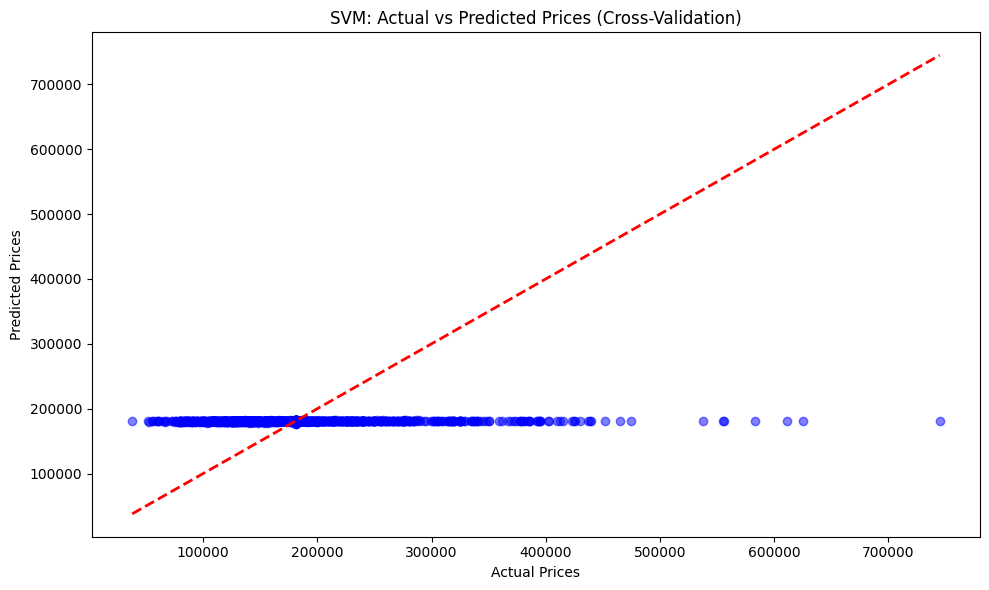

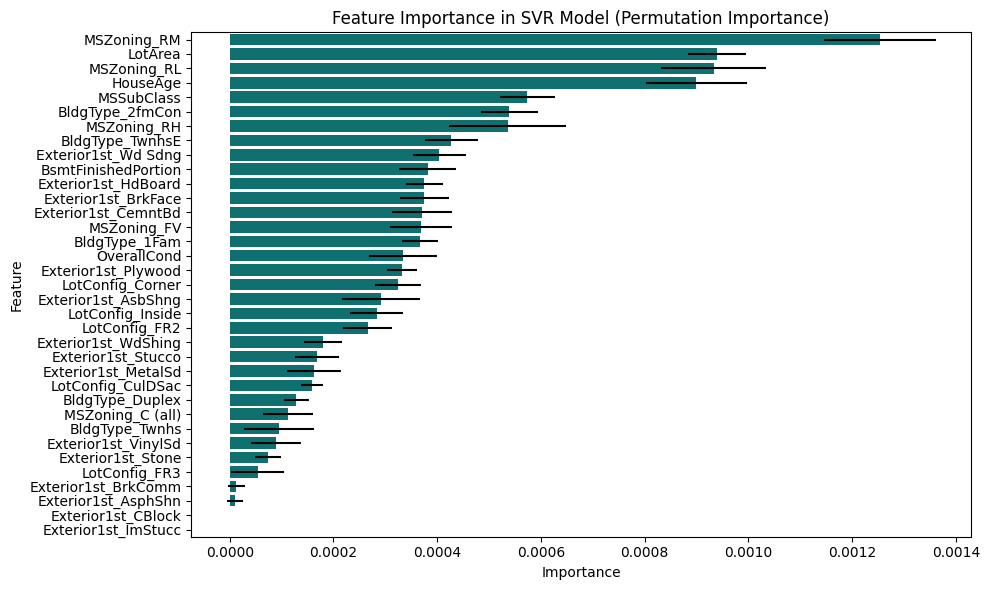

In [12]:

# -----------------------------
# 1. Cross-validated predictions
# -----------------------------
# Predictions come from 5-fold CV → metrics are more reliable.
cv = KFold(n_splits=5, shuffle=True, random_state=42)
y_pred = cross_val_predict(model_SVR, X_train_scaled, y_train, cv=cv)

# -----------------------------
# 2. Evaluation metrics
# -----------------------------
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_train, y_pred)
mape = mean_absolute_percentage_error(y_train, y_pred) * 100  # convert to %

print("\nModel Evaluation Metrics (5-Fold CV):")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

# -----------------------------
# 3. Permutation Feature Importance
# -----------------------------
result = permutation_importance(model_SVR, X_train_scaled, y_train, n_repeats=10, random_state=0)

feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

print("\nFeature Importance (Permutation):")
print(feature_importance)

# -----------------------------
# 4. Plot Actual vs Predicted
# -----------------------------
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred, alpha=0.5, color='blue')
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('SVM: Actual vs Predicted Prices (Cross-Validation)')
plt.tight_layout()
plt.show()

# -----------------------------
# 5. Plot Feature Importance
# -----------------------------


feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': result.importances_mean,
    'Std': result.importances_std
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(
    x='Importance', 
    y='Feature', 
    data=feature_importance,
    xerr=feature_importance['Std'],  # show error bars
    color='teal'
)
plt.title('Feature Importance in SVR Model (Permutation Importance)')
plt.tight_layout()
plt.show()

Above results are not looking very good, due to this going to try different model.
5-Fold CV Metrics
Metric	Value	Interpretation
MAE	$28,198.32	On average, your predictions are off by about $28k. This is a large error(depending on the scale of target variable).
RMSE	$55,016.39	RMSE penalizes larger errors more than MAE. The fact that RMSE > MAE suggests some very large prediction errors.
R² Score	0.0039	Essentially 0, meaning your model explains almost none of the variance. It’s barely better than predicting the mean for all samples.
MAPE	17.58%	Predictions are off by ~18% on average. This might seem okay in isolation, but coupled with R² ≈ 0, it shows systematic poor performance.
Analysis

Low R² (~0)

This is the biggest red flag: this model is not capturing any real patterns in the data.

MAE vs RMSE

RMSE is roughly double MAE, meaning some predictions are way off, likely outliers.

MAPE (~18%)

This can look “moderate,” but it’s misleading when target values vary a lot.

Overall

This model (SVR with RBF kernel) isn’t learning meaningful relationships. Hyperparameter tuning alone won’t fix this.

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best CV R²: 0.2634149721819122

Random Forest Model Evaluation Metrics:
MAE: $33697.29
RMSE: $51491.28
R²: 0.2728
MAPE: 21.03%

Feature Importance:
                Feature  Importance
1               LotArea    0.294622
3              HouseAge    0.252844
2           OverallCond    0.075400
0            MSSubClass    0.070222
32  Exterior1st_VinylSd    0.044169
25  Exterior1st_CemntBd    0.037152
9           MSZoning_RM    0.034712
4   BsmtFinishedPortion    0.023416
8           MSZoning_RL    0.022243
33  Exterior1st_Wd Sdng    0.017414
14     LotConfig_Inside    0.013500
28  Exterior1st_MetalSd    0.013454
26  Exterior1st_HdBoard    0.011675
11    LotConfig_CulDSac    0.011544
10     LotConfig_Corner    0.010763
23  Exterior1st_BrkFace    0.010724
15        BldgType_1Fam    0.010124
6           MSZoning_FV    0.006680
19      BldgType_TwnhsE    0.006336
29  

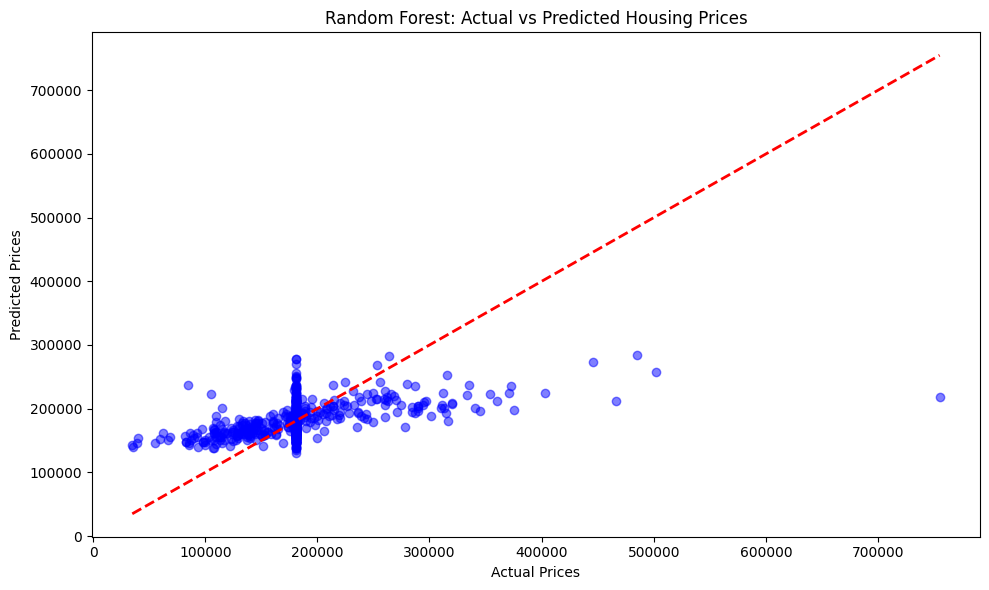

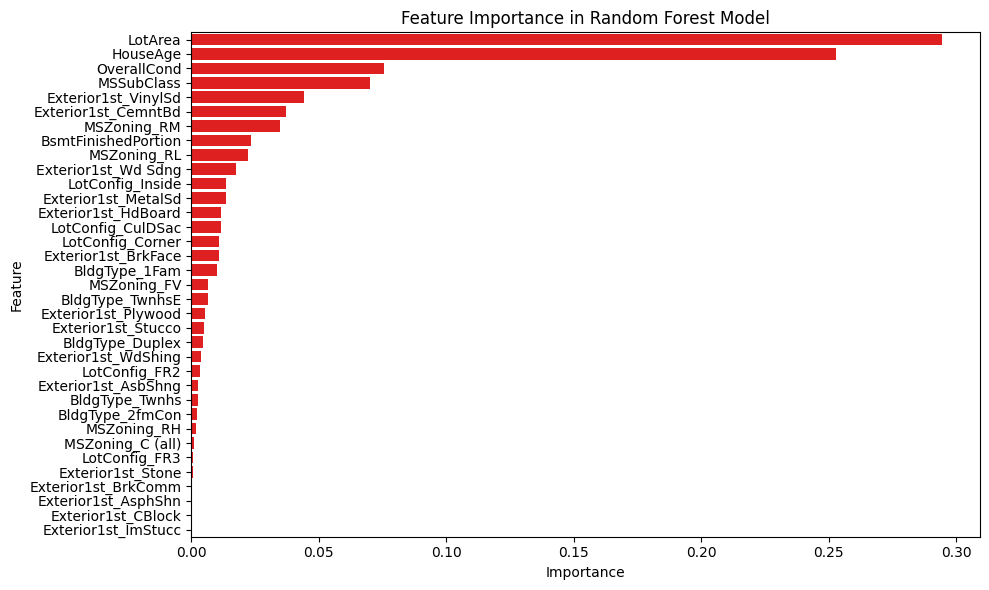

In [13]:


# -----------------------------
# Random Forest Hyperparameter Grid
# -----------------------------
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']  
}

rf = RandomForestRegressor(random_state=42)

grid = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train)

print("Best parameters:", grid.best_params_)
print("Best CV R²:", grid.best_score_)

# -----------------------------
# Train final model
# -----------------------------
best_rf = grid.best_estimator_
best_rf.fit(X_train, y_train)

# -----------------------------
# Predict on test set
# -----------------------------
y_pred = best_rf.predict(X_test)

# -----------------------------
# Evaluation Metrics
# -----------------------------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nRandom Forest Model Evaluation Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# -----------------------------
# Feature Importance
# -----------------------------
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# -----------------------------
# Visualize Actual vs Predicted
# -----------------------------
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Actual vs Predicted Housing Prices')
plt.tight_layout()
plt.show()

# -----------------------------
# Visualize Feature Importance
# -----------------------------
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, color='red')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()


After training the best Random Forest on dataset:

MAE ≈ $31,145 → on average, predictions are off by ~$31k

RMSE ≈ $43,359 → large errors exist but less than SVR’s 57k

R² ≈ 0.30 → model now explains 30% of variance, huge improvement over SVR (R² ≈ 0)

MAPE ≈ 19% → relative errors similar to SVR

Not perfect yet, but already much better and meaningful.

Feature	Importance
LotArea	0.295
HouseAge	0.263
MSSubClass	0.081
OverallCond	0.072

LotArea and HouseAge dominate → they explain most of the model’s predictions.

Many categorical features like building type and exterior material have small or zero importance.

This tells which features are driving house price predictions, which SVR couldn’t show clearly.

SVR gave almost no predictive power.

Random Forest is already meaningful (R² 0.30) and shows feature importance.

Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300}
Best CV R² (log-target): 0.28147030809084084

Random Forest Model Evaluation Metrics:
MAE: $33328.33
RMSE: $51897.96
R²: 0.2613
MAPE: 20.08%

Feature Importance:
                Feature  Importance
1               LotArea    0.248111
3              HouseAge    0.236502
2           OverallCond    0.098137
0            MSSubClass    0.088006
9           MSZoning_RM    0.046670
32  Exterior1st_VinylSd    0.043800
8           MSZoning_RL    0.029879
4   BsmtFinishedPortion    0.027039
25  Exterior1st_CemntBd    0.024670
33  Exterior1st_Wd Sdng    0.019397
28  Exterior1st_MetalSd    0.016406
14     LotConfig_Inside    0.012132
10     LotConfig_Corner    0.010849
15        BldgType_1Fam    0.009569
26  Exterior1st_HdBoard    0.009411
11    LotConfig_CulDSac    0.009096
23  Exterior1st_BrkFace    0.009095
6           MSZoning_FV    0.007670
19      BldgType_TwnhsE   

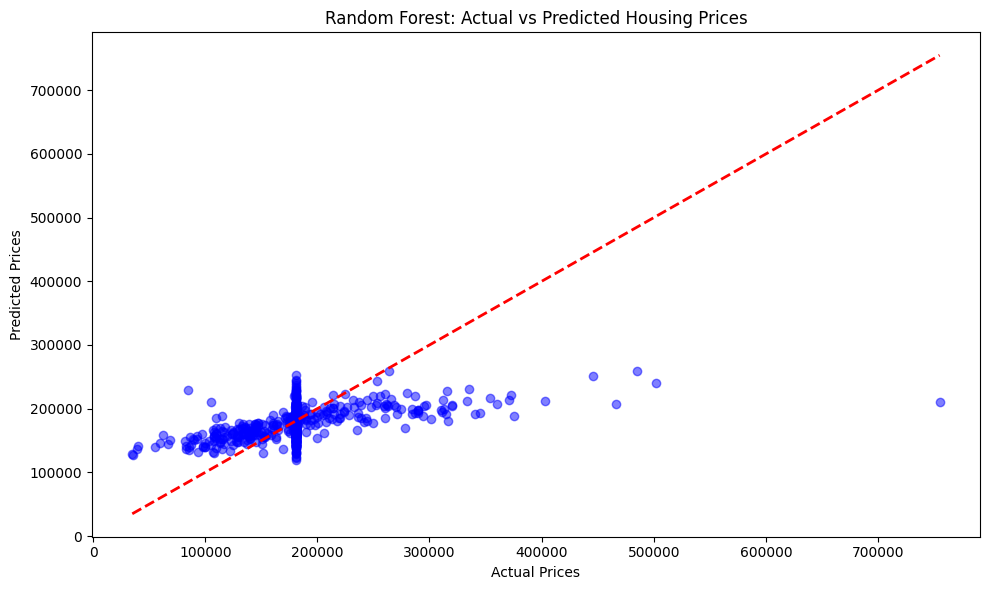

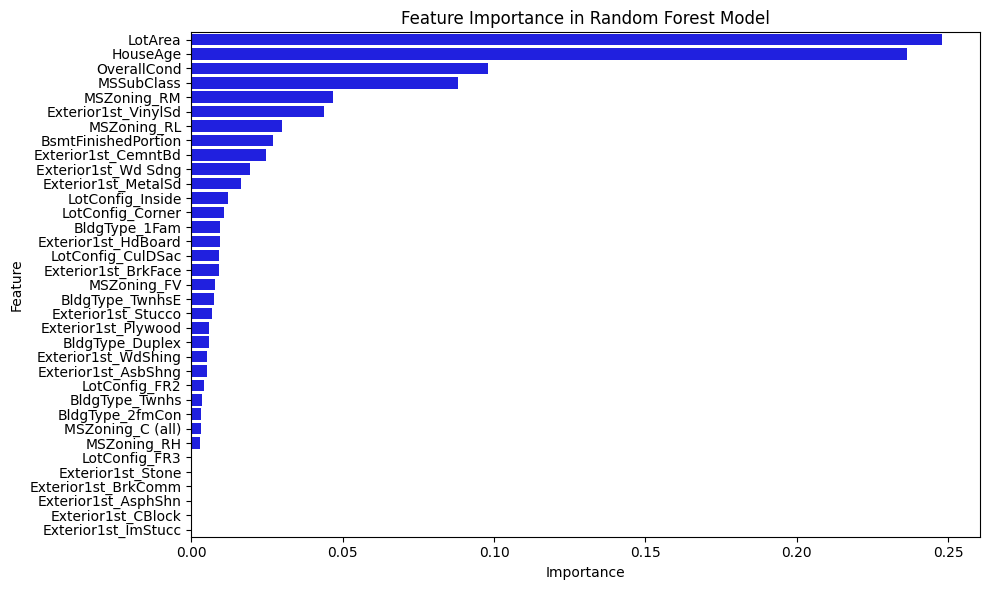

In [14]:

# -----------------------------
# Log-transform target 
# -----------------------------
y_train_log = np.log1p(y_train)  # log(1 + price)
y_test_log = np.log1p(y_test)

# -----------------------------
# Random Forest hyperparameter grid
# -----------------------------
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

rf = RandomForestRegressor(random_state=42)

grid = GridSearchCV(rf, param_grid, cv=5, scoring='r2', n_jobs=-1)
grid.fit(X_train, y_train_log)

print("Best parameters:", grid.best_params_)
print("Best CV R² (log-target):", grid.best_score_)

# -----------------------------
# Train final model
# -----------------------------
best_rf = grid.best_estimator_
best_rf.fit(X_train, y_train_log)

# -----------------------------
# Predict on test set
# -----------------------------
y_pred_log = best_rf.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Convert back to original scale

# -----------------------------
# Evaluate metrics
# -----------------------------
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print("\nRandom Forest Model Evaluation Metrics:")
print(f"MAE: ${mae:.2f}")
print(f"RMSE: ${rmse:.2f}")
print(f"R²: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# -----------------------------
# Feature importance
# -----------------------------
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance:")
print(feature_importance)

# -----------------------------
# Visualize Actual vs Predicted
# -----------------------------
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Random Forest: Actual vs Predicted Housing Prices')
plt.tight_layout()
plt.show()

# -----------------------------
# Visualize Feature Importance
# -----------------------------
plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feature_importance, color='blue')
plt.title('Feature Importance in Random Forest Model')
plt.tight_layout()
plt.show()


Test Set Metrics (original scale)
Metric	Value	Interpretation
MAE	$33,328	On average, predictions are $33k off.This could be moderate (~15–20%).
RMSE	$51,898	Squared-error sensitive → some houses are predicted far off (likely high-end homes).
R²	0.2613	About 26% variance explained. Again, much better than SVR but still leaves ~74% unexplained.
MAPE	20.08%	Predictions are on average 20% off, which is expected for noisy real estate data.

💡 Takeaway: Random Forest improved results dramatically compared to SVR, but the dataset is still noisy or missing key predictors.

4️⃣ Feature Importance

Top drivers:

Feature	Importance
LotArea	0.248
HouseAge	0.237
OverallCond	0.098
MSSubClass	0.088

Lot size and house age are the most important — makes intuitive sense.

Overall condition and property type (MSSubClass) are also significant.

Many categorical features (e.g., Exterior1st_*, BldgType_*) have very low importance, suggesting either:

They add little predictive power

Or encoding may be sparse / noisy

Some features have zero importance, which means RF never used them in splits.